In [1]:
import numpy as np
import pulp
import re

import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

In [2]:
# The patio is defined in paver units, where the paver sizes are 1x2, 2x2, 3x2, and 3x3
# A paver's top left corner will correspond to a problem variable. The problem will be built by
# requiring that each space is occupied only by one paver. The paver types are separated in pages,
# with each possible orientation (2) in a book.
size = (13, 22)
shapes = [(1, 2), (2, 2), (3, 2), (3, 3)]
count = (23, 21, 26, 0)
num_shapes = len(shapes)

paversqft = 0
for kk in range(num_shapes):
    paversqft += shapes[kk][0]*shapes[kk][1]*count[kk]

print('You want a {} sq-unit patio and have {} total sq-units of pavers.'.format(
    size[0]*size[1], paversqft))

prob = pulp.LpProblem('Paver Layout Solver')

var = np.array(
    [[[[pulp.LpVariable('n{}_{}_{}_{}'.format(ii,jj,kk,mm), cat='Binary')
        for mm in range(2)]
       for kk in range(num_shapes)]
      for jj in range(size[1])]
     for ii in range(size[0])])

# Define rules:
# A space may contain only one paver 
for ii in range(size[0]):
    for jj in range(size[1]):
        # Pavers whose top left corner are here obviously occupy this space.
        candidates = 0 # var[ii, jj, :, :].sum()
        # Per each paver size, check the spaces above and to the left to see if it includes this space.
        for kk in range(num_shapes):
            for ii2 in range(ii+1):
                for jj2 in range(jj+1):
                    if ii2+shapes[kk][0] > ii and jj2+shapes[kk][1] > jj:
                        candidates += var[ii2, jj2, kk, 0]
                    if ii2+shapes[kk][1] > ii and jj2+shapes[kk][0] > jj:
                        candidates += var[ii2, jj2, kk, 1]
        # Only allow one of the candidates to be true.
        prob += candidates == 1
# Don't allow pavers to extend past patio edges.
for ii in range(size[0]):
    for jj in range(size[1]):
        for kk in range(num_shapes):
            if ii+shapes[kk][0] > size[0] or jj+shapes[kk][1] > size[1]:
                prob += var[ii, jj, kk, 0] == 0
            if ii+shapes[kk][1] > size[0] or jj+shapes[kk][0] > size[1]:
                prob += var[ii, jj, kk, 1] == 0
# Square blocks only need one orientation; force the other to be 0.
for ii in range(size[0]):
    for jj in range(size[1]):
        for kk in range(num_shapes):
            if shapes[kk][0] == shapes[kk][1]:
                prob += var[ii, jj, kk, 1] == 0
"""# Don't allow seams to run the full length of the patio
widths = np.array([s[0] for s in shapes]).reshape((1, 1, num_shapes))
heights = np.array([s[1] for s in shapes]).reshape((1, 1, num_shapes))
horz_seams = (var[1:,:,:,0]*widths).sum(axis=2).sum(axis=1) + (var[1:,:,:,1]*heights).sum(axis=2).sum(axis=1)
vert_seams = (var[:,1:,:,0]*heights).sum(axis=2).sum(axis=0) + (var[:,1:,:,1]*widths).sum(axis=2).sum(axis=0)
for ii in range(size[0]-1):
    prob += horz_seams[ii] <= size[0] - 4
for ii in range(size[1]-1):
    prob += vert_seams[ii] <= size[1] - 4"""
# Only use up to the available number of blocks
for kk in range(num_shapes):
    prob += var[:, :, kk, :].sum() <= count[kk]
# Disallow identical neighbors (too constraining as pairs, just disallow 3 or more)
for ii in range(size[0]):
    for jj in range(size[1]):
        for kk in range(num_shapes):
            for mm in range(2):
                if ii + 3*shapes[kk][mm] <= size[0]: # disallow three in a row
                    prob += var[ii, jj, kk, mm] + var[ii+shapes[kk][mm], jj, kk, mm] + var[ii+2*shapes[kk][mm], jj, kk, mm] <= 2
                if jj + 3*shapes[kk][1-mm] <= size[1]: # disallow three in a row
                    prob += var[ii, jj, kk, mm] + var[ii, jj+shapes[kk][1-mm], kk, mm] + var[ii, jj+2*shapes[kk][1-mm], kk, mm] <=2
                if ii + 2*shapes[kk][mm] <= size[0] and jj + 2*shapes[kk][1-mm] <= size[1]: # disallow three in a square
                    prob += var[ii, jj, kk, mm] + var[ii+shapes[kk][mm], jj, kk, mm] + var[ii, jj+shapes[kk][1-mm], kk, mm] + var[ii+shapes[kk][mm], jj+shapes[kk][1-mm], kk, mm] <=2

solutions = []
for _ in range(18):  # desired number of solutions
    
    prob.solve()
    print('{}) Status: {} ({})'.format(count, pulp.LpStatus[prob.status], prob.status))

    if prob.status != 1:
        break
    
    values = np.array([int(x.varValue) for x in prob.variables()[1:]]) # w/o dummy variable
    names = np.array([x.name for x in prob.variables()[1:]])
    indices = [tuple(int(r) for r in re.findall('\d+', name)) for name in names]

    soln = np.zeros(var.shape, dtype=int)
    for val, idx in zip(values, indices):
        soln[idx] = val

    solutions.append(soln)
    
    # Find a new pattern by forcing at least one choice to be different
    prob += pulp.lpSum([var[ii, jj, kk, mm]
        for ii in range(size[0])
        for jj in range(size[1])
        for kk in range(num_shapes)
        for mm in range(2)
        if soln[ii, jj, kk, mm]]) <= soln.sum()-1

You want a 286 sq-unit patio and have 286 total sq-units of pavers.
0) Status: Optimal (1)
1) Status: Optimal (1)
2) Status: Optimal (1)
3) Status: Optimal (1)
4) Status: Optimal (1)
5) Status: Optimal (1)
6) Status: Optimal (1)
7) Status: Optimal (1)
8) Status: Optimal (1)
9) Status: Optimal (1)
10) Status: Optimal (1)
11) Status: Optimal (1)
12) Status: Optimal (1)
13) Status: Optimal (1)
14) Status: Optimal (1)
15) Status: Optimal (1)
16) Status: Optimal (1)
17) Status: Optimal (1)
18) Status: Optimal (1)
19) Status: Optimal (1)
20) Status: Optimal (1)


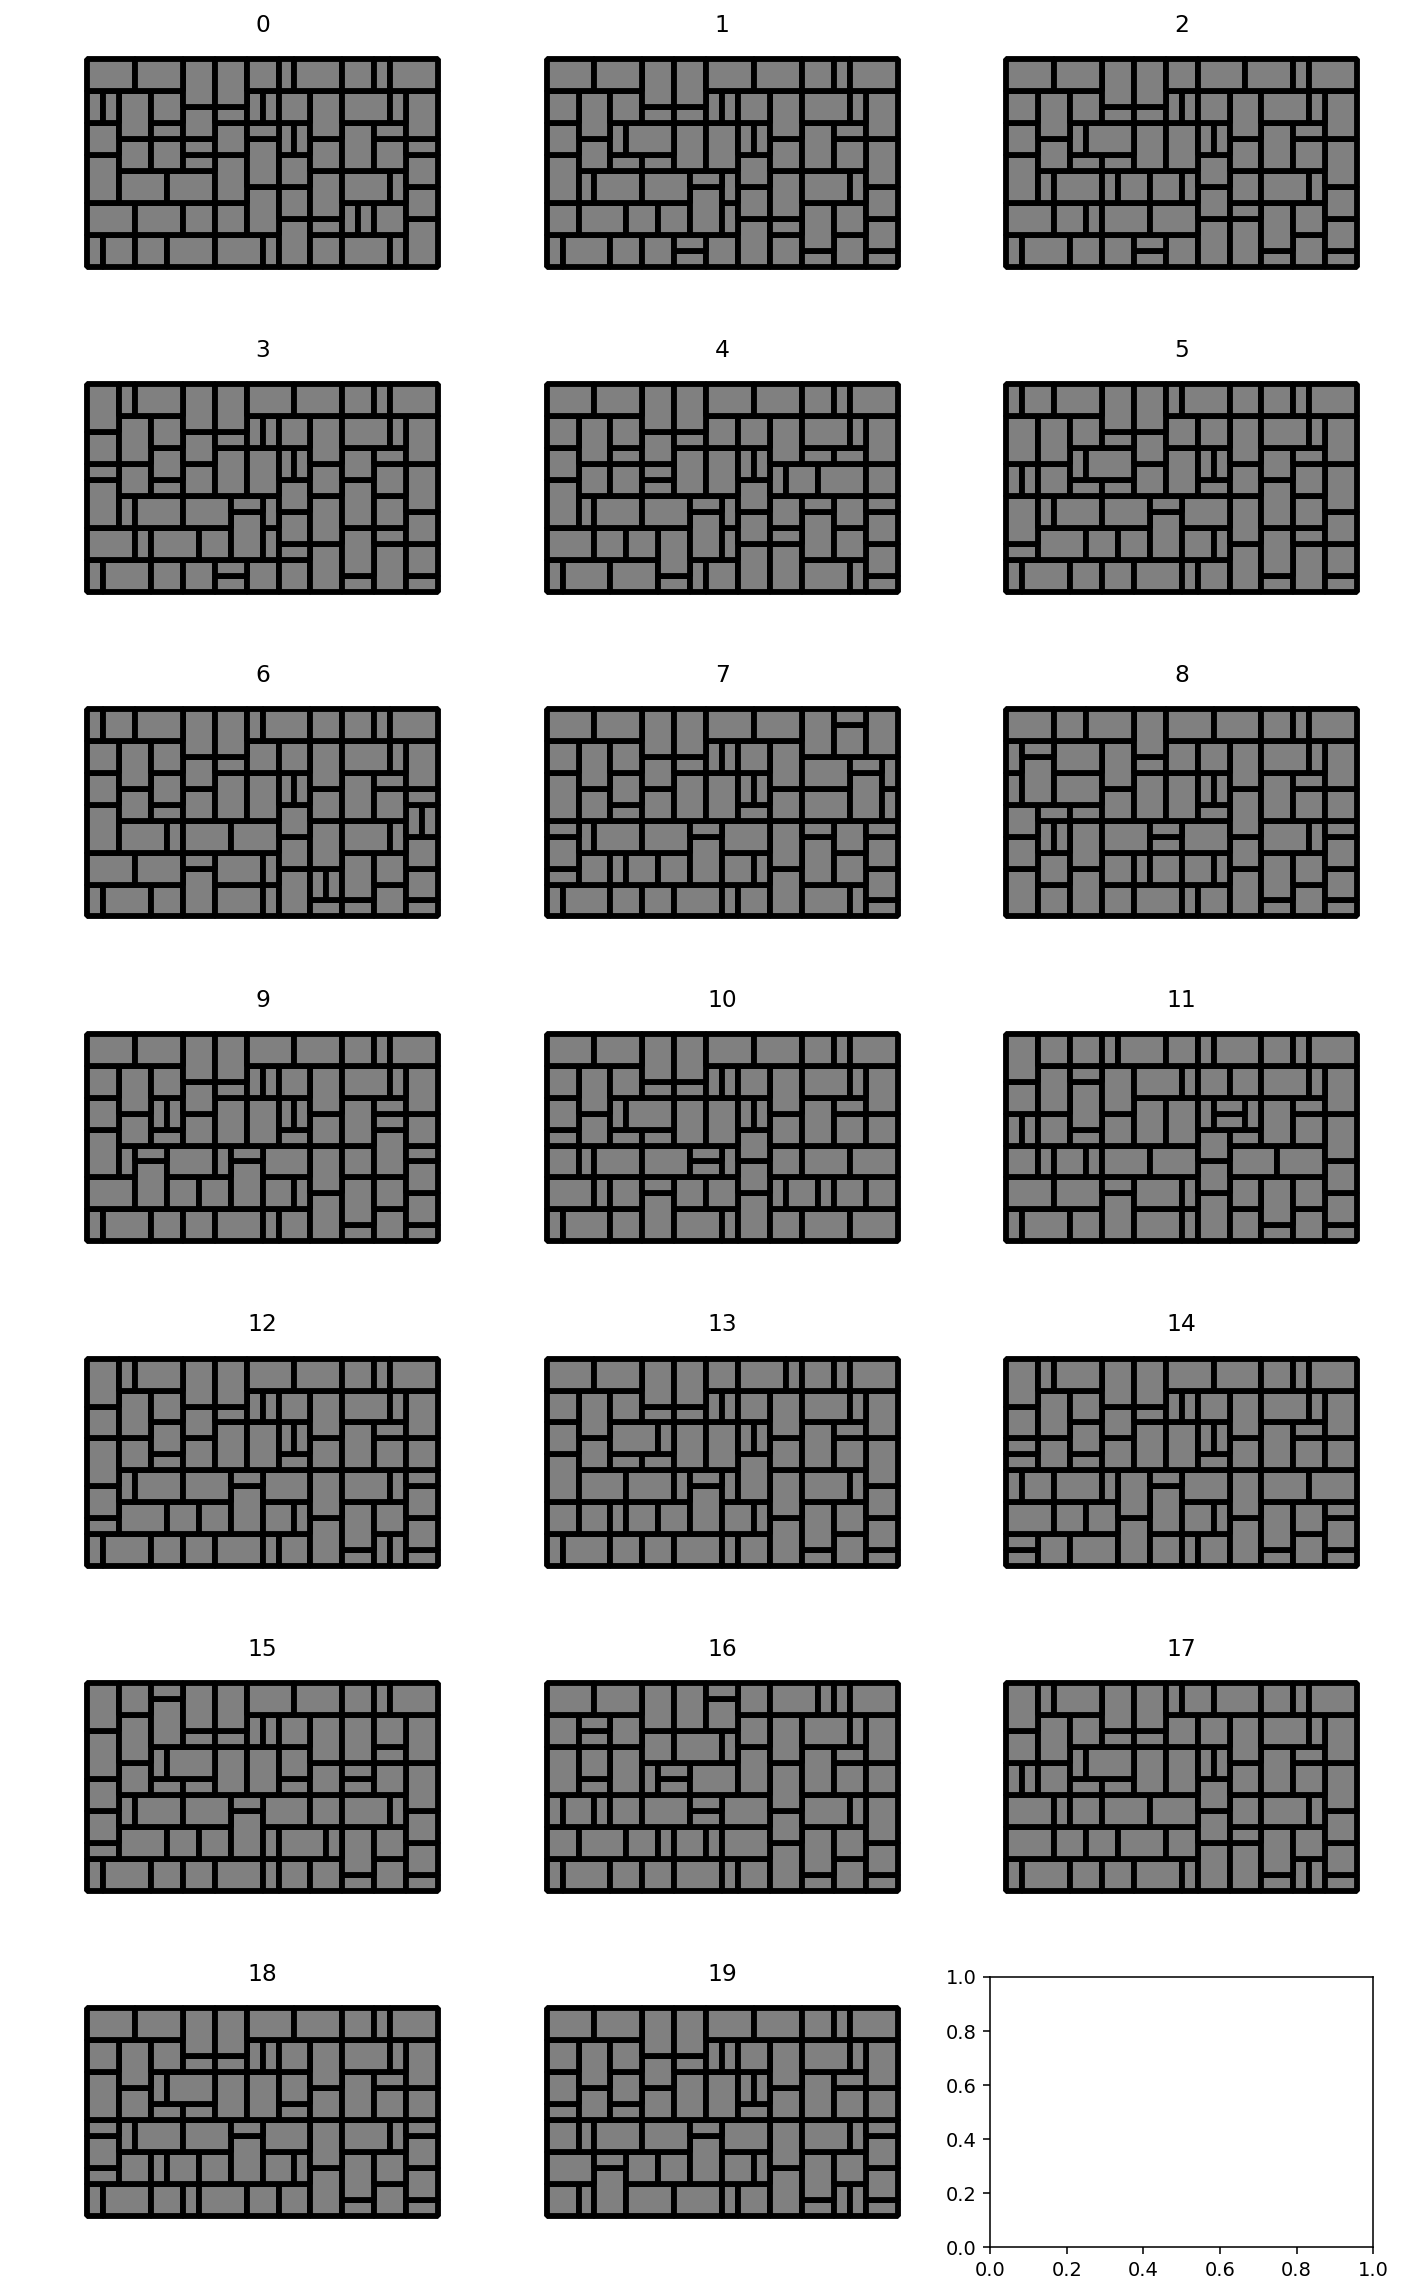

In [3]:
m = 3
n = (len(solutions) + m - 1) // m
fig, axs = plt.subplots(n, m, sharex=False, figsize=(12, 3*n), dpi=140)
for ax, (ii, soln) in zip(axs.flatten().tolist(), enumerate(solutions)):
    # Draw pattern
    hatches = ['/', '\\', 'x', '+']
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xlim([-1, size[1]+1])
    ax.set_ylim([-1, size[0]+1])
    ax.axis('off')
    ax.set_title(ii)
    for ii in range(size[0]):
        for jj in range(size[1]):
            for kk in range(num_shapes):
                shape = shapes[kk]
                shape = shape[1], shape[0] # image is transposed
                for mm in range(2):
                    if mm > 0:
                        shape = shape[1], shape[0]
                    if soln[ii, jj, kk, mm] != 0:
                        ax.add_patch(patches.Rectangle(
                            (jj, ii), *shape, fill=True, linewidth=3, # hatch=hatches[kk],
                            joinstyle='bevel', facecolor='grey', edgecolor='black'))